Estimated vmax: 0.08585727091229756, Estimated Km: 6.561877540332034
Lineweaver: vmax = 0.08474334166355973, Km = 6.392313059014176
Dixon: vmax = 0.013191210412604727, Km = 0.15457448490277692
Eadie: vmax = 0.08558065485130675, Km = 6.515470111144498


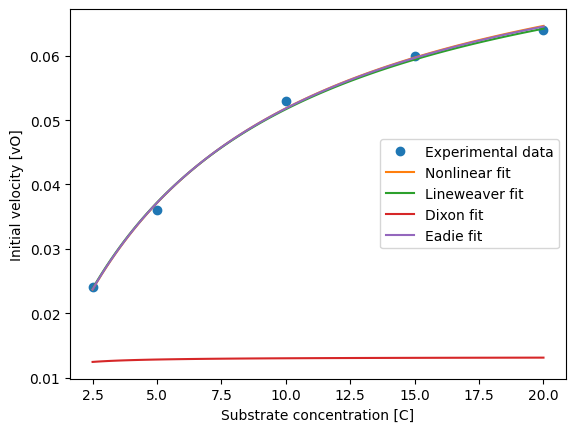

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Gauss-Newton algorithm with damping factor for nonlinear least squares fitting
def gauss_newton(C, vO, initial_guess=(0.1, 0.1), max_iterations=100, tolerance=1e-5, damping=0.00001):
    # Initialize parameters
    vmax, Km = initial_guess

    for iteration in range(max_iterations):
        # Compute the residuals and the Jacobian matrix
        residuals = []
        jacobian = []
        for i in range(len(C)):
            predicted_vO = vmax * C[i] / (Km + C[i])
            residual = vO[i] - predicted_vO
            residuals.append(residual)
            # Partial derivatives of the model function with respect to the parameters
            jacobian_row = [C[i] / (Km + C[i]), -vmax * C[i] / (Km + C[i])**2]
            jacobian.append(jacobian_row)

        # Compute the transpose of the Jacobian matrix
        jacobian_transpose = [list(col) for col in zip(*jacobian)]

        # Compute the product of the transpose of the Jacobian and the residuals
        jacobian_transpose_residuals = [sum(jacobian_transpose[i][j] * residuals[j] for j in range(len(C))) for i in range(2)]

        # Compute the product of the transpose of the Jacobian and the Jacobian itself
        jacobian_transpose_jacobian = [[sum(jacobian_transpose[i][k] * jacobian[k][j] for k in range(len(C))) for j in range(2)] for i in range(2)]

        # Add damping factor to the diagonal elements of J^T*J
        jacobian_transpose_jacobian[0][0] += damping
        jacobian_transpose_jacobian[1][1] += damping

        # Solve the normal equations J^T*J*delta = J^T*r for delta using inverse of 2x2 matrix
        det = jacobian_transpose_jacobian[0][0] * jacobian_transpose_jacobian[1][1] - jacobian_transpose_jacobian[0][1] * jacobian_transpose_jacobian[1][0]
        if abs(det) < tolerance:
            raise ValueError("Jacobian is close to singular and cannot be inverted.")

        inv_jacobian_transpose_jacobian = [
            [jacobian_transpose_jacobian[1][1] / det, -jacobian_transpose_jacobian[0][1] / det],
            [-jacobian_transpose_jacobian[1][0] / det, jacobian_transpose_jacobian[0][0] / det]
        ]

        # Compute delta
        delta = [sum(inv_jacobian_transpose_jacobian[i][j] * jacobian_transpose_residuals[j] for j in range(2)) for i in range(2)]

        # Update parameters
        vmax += delta[0]
        Km += delta[1]

        # Check for convergence
        if max(abs(delta[0]), abs(delta[1])) < tolerance:
            break

    return vmax, Km

# Given data
C = [2.5, 5.0, 10.0, 15.0, 20.0]
vO = [0.024, 0.036, 0.053, 0.060, 0.064]

# Perform Gauss-Newton nonlinear regression to estimate vmax and Km
vmax_estimated, Km_estimated = gauss_newton(C, vO)
print(f"Estimated vmax: {vmax_estimated}, Estimated Km: {Km_estimated}")

# Michaelis-Menten model function
def michaelis_menten(C, vmax, Km):
    return (vmax * C) / (Km + C)

# Linear least squares for Lineweaver, Dixon, and Eadie forms

# Lineweaver linearization
X_LB = [1/c for c in C]
Y_LB = [1/v for v in vO]

# Dixon linearization
X_D = C
Y_D = [c/v for c, v in zip(C, vO)]

# Eadie linearization
X_EH = [v/c for v, c in zip(vO, C)]
Y_EH = vO

# Linear least squares function
def linear_least_squares(X, Y):
    n = len(X)
    sum_x = sum(X)
    sum_y = sum(Y)
    sum_xy = sum(x*y for x, y in zip(X, Y))
    sum_xx = sum(x*x for x in X)

    # Calculate slope (m) and intercept (b) for y = mx + b
    m = (n*sum_xy - sum_x*sum_y) / (n*sum_xx - sum_x**2)
    b = (sum_y - m*sum_x) / n

    return m, b

# Calculate parameters using linear least squares for each linearization
m_LB, b_LB = linear_least_squares(X_LB, Y_LB)
m_D, b_D = linear_least_squares(X_D, Y_D)
m_EH, b_EH = linear_least_squares(X_EH, Y_EH)

# Calculate vmax and Km from the slopes and intercepts
vmax_LB = 1 / b_LB
Km_LB = m_LB / b_LB

vmax_D = 1 / b_D
Km_D = m_D / b_D

vmax_EH = b_EH
Km_EH = -m_EH

# Print the results
print(f"Lineweaver: vmax = {vmax_LB}, Km = {Km_LB}")
print(f"Dixon: vmax = {vmax_D}, Km = {Km_D}")
print(f"Eadie: vmax = {vmax_EH}, Km = {Km_EH}")

# Plotting the results for visualization
C_range = np.linspace(min(C), max(C), 100)
plt.plot(C, vO, 'o', label='Experimental data')
plt.plot(C_range, michaelis_menten(C_range, vmax_estimated, Km_estimated), label='Nonlinear fit')
plt.plot(C_range, michaelis_menten(C_range, vmax_LB, Km_LB), label='Lineweaver fit')
plt.plot(C_range, michaelis_menten(C_range, vmax_D, Km_D), label='Dixon fit')
plt.plot(C_range, michaelis_menten(C_range, vmax_EH, Km_EH), label='Eadie fit')
plt.xlabel('Substrate concentration [C]')
plt.ylabel('Initial velocity [vO]')
plt.legend()
plt.show()
